In [ ]:
!pip install --upgrade scikit-learn
!pip install tensorflow-data-validation

In [1]:
import pandas as pd


data = pd.read_csv('datasets/diamonds/diamonds.csv')

In [2]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


### Dataset First look

In [ ]:
import tensorflow_data_validation as tfdv

stats = tfdv.generate_statistics_from_dataframe(data, tfdv.StatsOptions(label_feature='price'))
tfdv.visualize_statistics(stats)

Output:
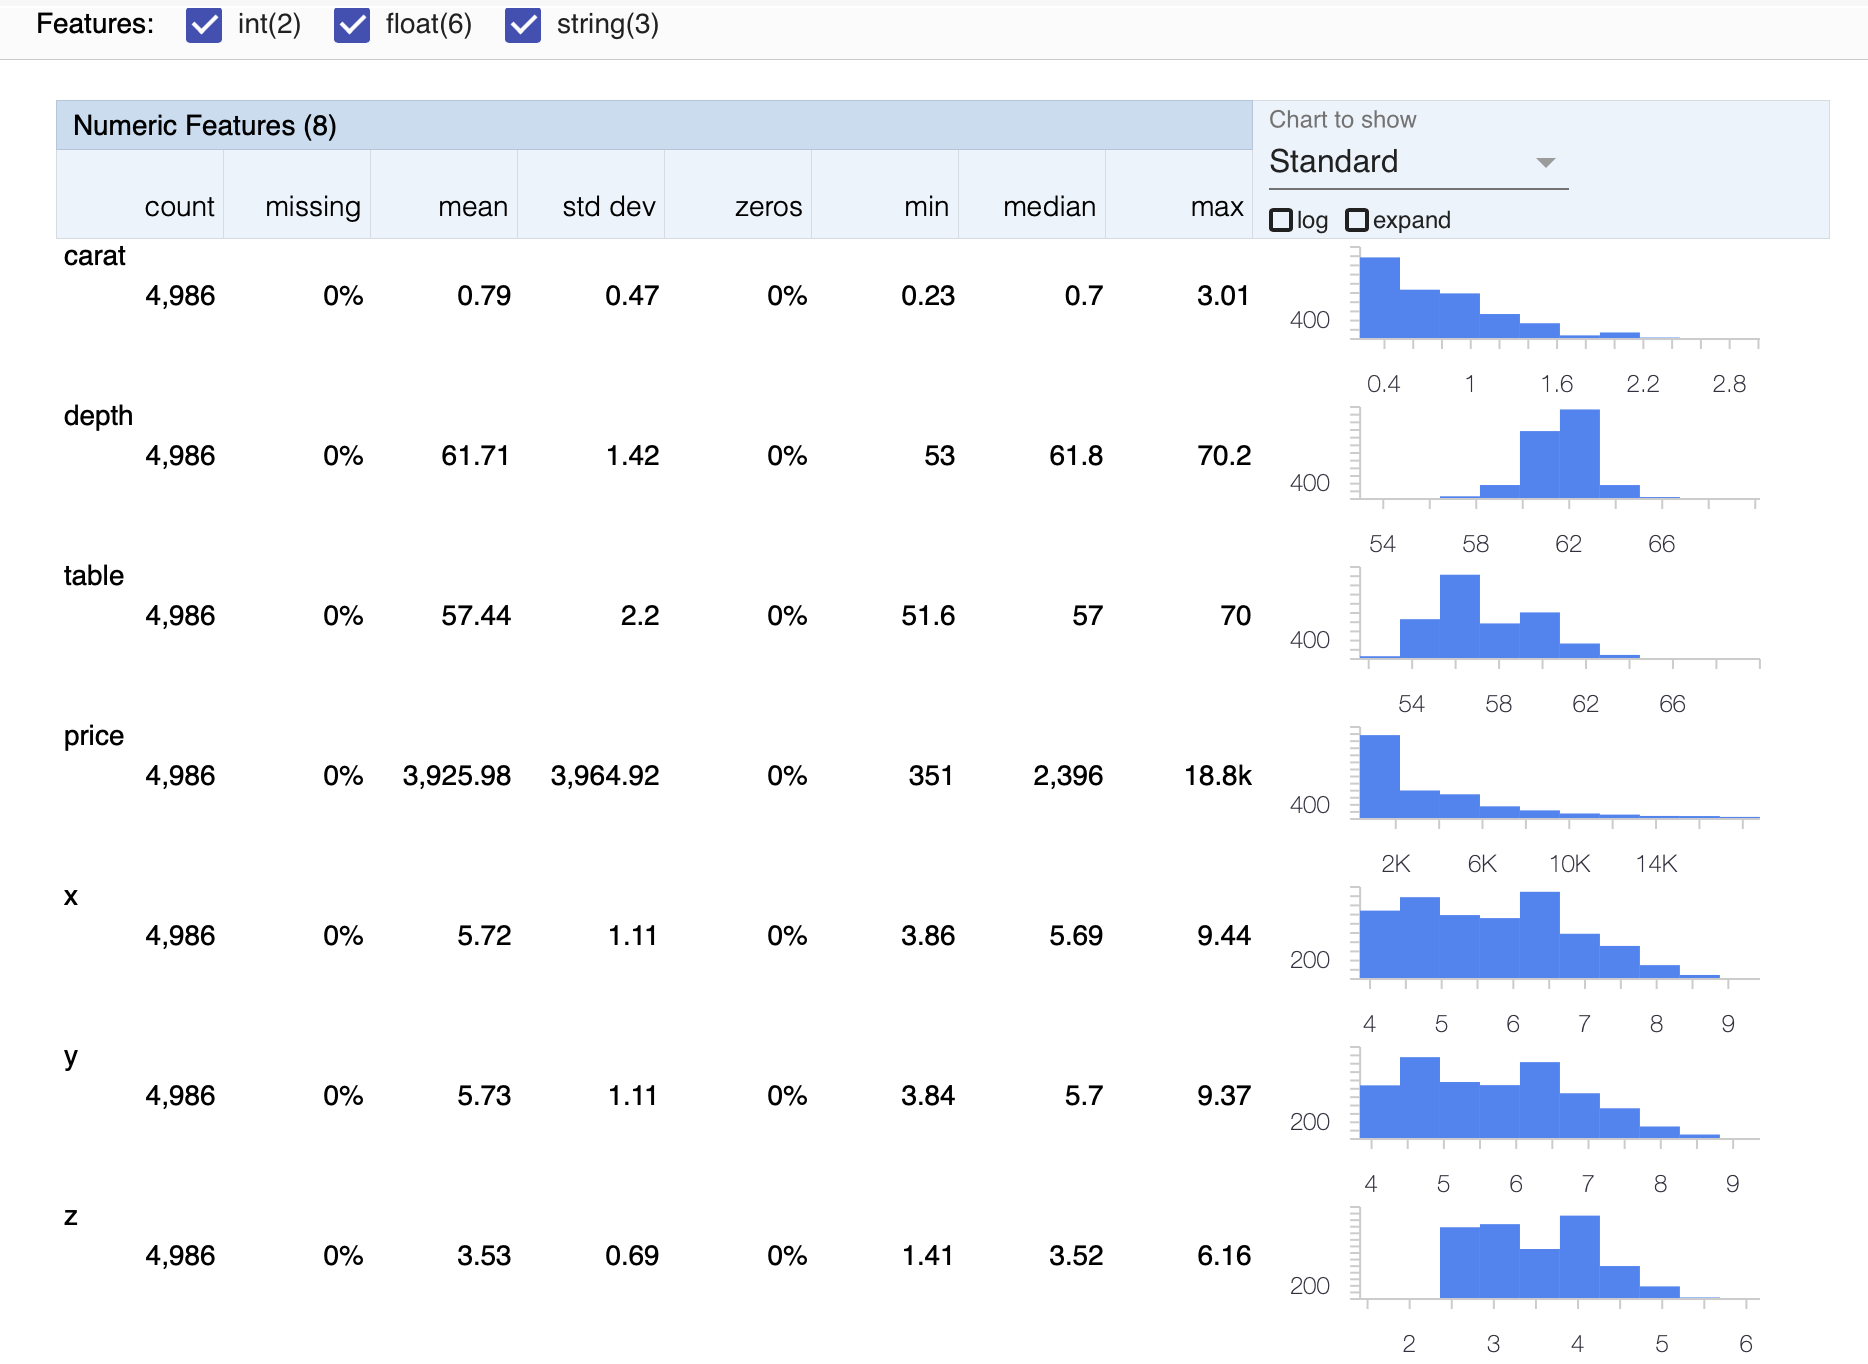
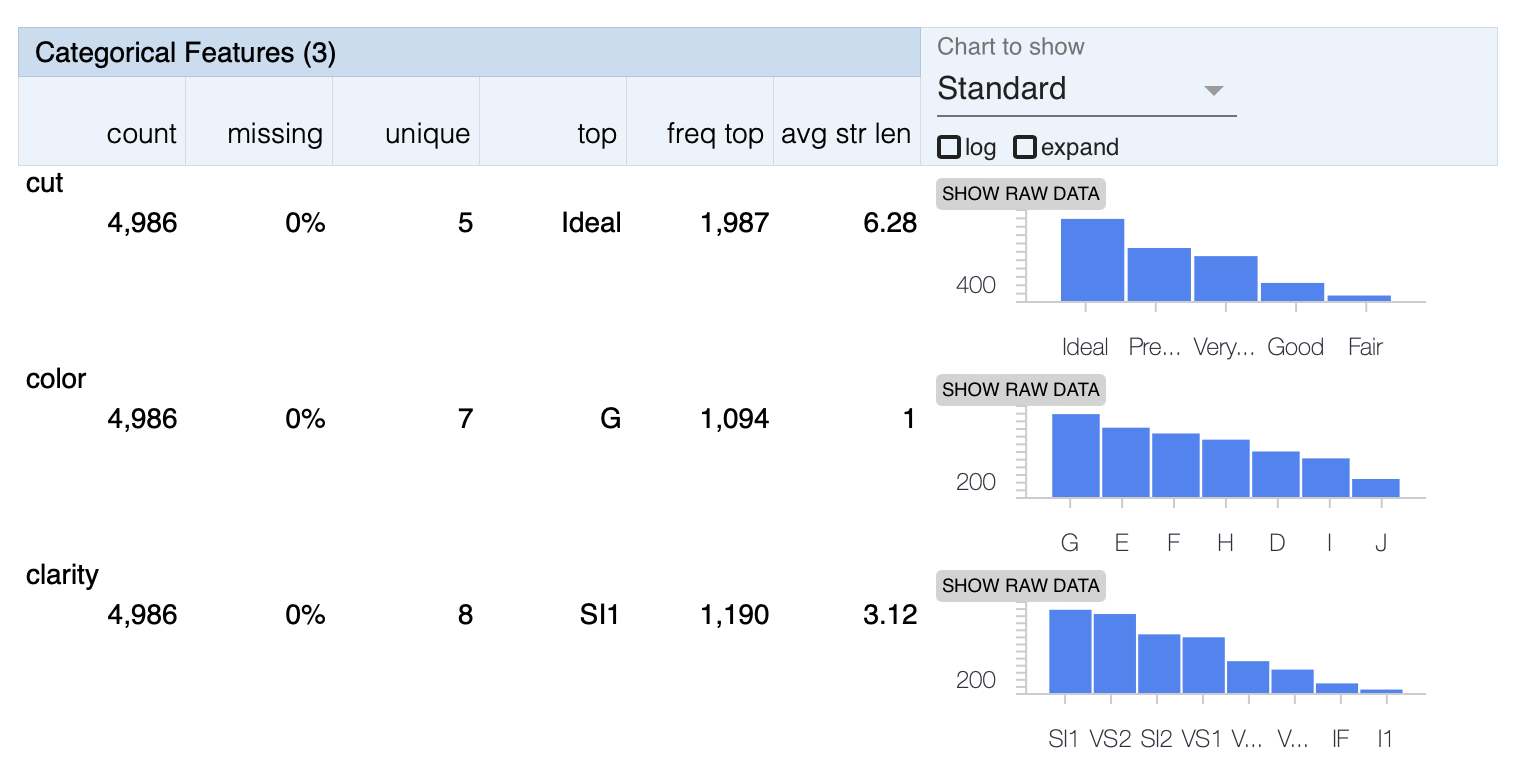

> The dataset seems complete, and the variables follow a standard distribution. However, there are several points to consider
>
> Review:
> - The dataset has negative prices (-1)
> - Some sizes on the x, y, z axes are 0
> - Check distributions with long tails (outliers)
> - Check categorical features
> 
> To Do:
> - Encode categorical features
> - Scale numerical variables

### Preprocess

REVIEW: price = -1

In [4]:
data.loc[data['price'] <= 10]

,carat,cut,color,clarity,depth,table,price,x,y,z
331,1.00,Good,F,SI1,64.1,60.0,-1,6.25,6.19,3.99
2121,0.34,Ideal,E,VS2,59.8,56.0,-1,4.55,4.54,2.72
2484,1.75,Ideal,J,SI1,63.3,59.0,-1,7.63,7.57,4.81
2933,1.51,Ideal,H,VS2,62.5,55.0,-1,7.29,7.34,4.57
3155,0.31,Ideal,G,VS2,61.7,57.0,-1,4.33,4.36,2.68
3317,1.02,Premium,D,VS2,59.8,61.0,-1,6.61,6.54,3.93
3445,0.30,Premium,H,SI1,59.3,59.0,-1,4.38,4.36,2.59
3904,0.90,Very Good,G,SI2,64.2,56.0,-1,6.04,6.11,3.90
3980,0.41,Very Good,H,VS2,63.4,58.0,-1,4.77,4.66,2.99
4188,0.79,Ideal,H,VVS1,62.0,56.0,-1,5.92,5.96,3.68


In [5]:
data.loc[data['price'] > 10].head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


> Comparing these two tables, we see that the price behavior is illogical since the diamonds seem good. So, I will delete the data.

In [6]:
data = data.loc[data['price'] != -1]

REVIEW: sizes = 0

In [7]:
data.loc[data['x'] < 3]  # (El numero 3 no es arbitrario, es un valor tomado gracias a ver la distribucion de la data)

,carat,cut,color,clarity,depth,table,price,x,y,z
4321,2.25,Premium,H,SI2,62.8,59.0,18034,0.0,0.0,0.0


> We can see that the price is expensive and the diamond doesn't exists. So I will drop it

In [8]:
data = data.loc[data['x'] != 0]

REVIEW: Checking outliers



In [9]:
data.loc[data['table'] > 70]

,carat,cut,color,clarity,depth,table,price,x,y,z
679,2.01,Fair,F,SI1,58.6,95.0,13387,8.32,8.31,4.87


In [10]:
data.loc[data['depth'] < 50]

,carat,cut,color,clarity,depth,table,price,x,y,z
1889,1.0,Fair,G,VS2,44.0,53.0,4032,6.31,6.24,4.12


In [11]:
data.loc[data['carat'] > 3.01]

,carat,cut,color,clarity,depth,table,price,x,y,z
3299,4.13,Fair,H,I1,64.8,61.0,17329,10.0,9.85,6.43


> I save the outliers and create a dataset without outliers

In [12]:
outliers = data.loc[data.index.isin((3299, 679, 1889))]

In [13]:
data = data.drop(outliers.index)

REVIEW: Categorical features

In [14]:
data['cut'].unique()

array(['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'], dtype=object)

In [15]:
data['color'].unique()

array(['H', 'I', 'F', 'G', 'E', 'D', 'J'], dtype=object)

In [16]:
data['clarity'].unique()

array(['SI2', 'SI1', 'VS2', 'IF', 'VVS2', 'VS1', 'I1', 'VVS1'],
      dtype=object)

> Categorical features looks good

To Do

In [17]:
import numpy as np
from typing import Literal


def oh_encoder(data, col_name):
    """One hot encoder"""
    encoded_df = pd.get_dummies(data[col_name], prefix=col_name)
    return data.drop(columns=[col_name]).join(encoded_df)

def label_encoder(data, col_name):
    """Label encoder"""
    label_map = {name:idx for idx, name in enumerate(data[col_name].unique())}
    data[col_name] = data[col_name].map(lambda x: label_map[x])
    return data

def num_scaler(data, col_name):
    """Standard scaler"""
    data[col_name] -= data[col_name].mean()
    data[col_name] /= data[col_name].std()
    return data

def preprocess(
    data: pd.DataFrame,
    cat_features: list[str],
    num_features: list[str],
    encoder_type: Literal['label', 'ohe'] = 'ohe'
) -> pd.DataFrame:
    # Data follows simple distributions so I'll use standard scaler for numerical features
    # Also for categorical features I'll use vectors

    d = data.copy()
    cat_encoder = oh_encoder
    if encoder_type == 'label':
        cat_encoder = label_encoder

    for col_name in d.columns:
        if col_name in cat_features:
            d = cat_encoder(d, col_name)
        elif col_name in num_features:
            d = num_scaler(d, col_name)

    return d

In [18]:
CATEGORICAL_FEATURES = ['cut', 'color', 'clarity']
NUMERICAL_FEATURES = ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']

le_data = preprocess(data, CATEGORICAL_FEATURES, NUMERICAL_FEATURES, encoder_type='label')
ohe_data = preprocess(data, CATEGORICAL_FEATURES, NUMERICAL_FEATURES, encoder_type='ohe')

In [19]:
le_data

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.659294,0,0,0,0.200743,-1.110873,0.203520,0.794446,0.833194,0.840169
1,1.067542,0,0,1,0.622472,-0.655390,0.629968,1.108541,1.086053,1.189458
2,0.874161,1,1,1,-0.431851,0.255577,0.399469,1.036748,0.968654,0.942045
3,1.518764,0,2,1,-0.572427,-0.655390,1.221597,1.530325,1.474372,1.407764
4,0.229558,2,2,2,-0.010122,-0.199906,0.142995,0.399585,0.435844,0.418111
...,...,...,...,...,...,...,...,...,...,...
4995,-0.887753,0,0,4,0.411607,-1.885194,-0.780260,-0.964483,-0.936820,-0.906277
4996,-0.995187,1,3,4,-0.291274,0.711060,-0.756302,-1.143966,-1.180648,-1.182797
4997,0.981595,0,6,4,0.271031,-0.655390,0.517997,0.973929,1.004777,1.029367
4998,-1.038161,1,2,2,0.833336,0.255577,-0.787825,-1.269604,-1.316109,-1.211905


### Correlations

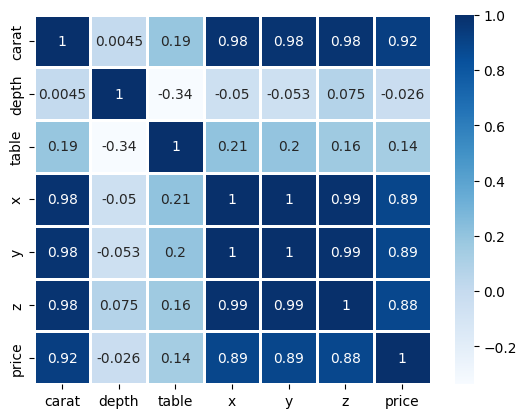

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.heatmap(le_data[NUMERICAL_FEATURES].corr(), cmap='Blues', linewidths=1, label='price', annot=True)
plt.show()

> We can see that the features "depth" and "table" have not correlation with the price nor features which do have correlations with price. Also "x", "y" and "z" are overcorrelated. Then I'll take one of them

In [21]:
NO_FEATURES = ['depth', 'table', 'y', 'z']
LABEL = 'price'

filtered_data = ohe_data[list(filter(lambda x: not x in NO_FEATURES, ohe_data.columns))]

### Machine Learning Models Benchmark

In [22]:
import sklearn.metrics as mets

class BenchmarkUtils:
    @staticmethod
    def split_dataset(data, features, label, train_pct=0.7, shuffle=False):
        d = data.copy()
        if shuffle:
            d = d.sample(frac=1)
        s = int(train_pct * d.shape[0])
        X_train, y_train = d[features][:s].to_numpy(), d[label][:s].to_numpy()
        X_test, y_test = d[features][s:].to_numpy(), d[label][s:].to_numpy()
        return  X_train, y_train.reshape(-1), X_test, y_test.reshape(-1)

    @staticmethod
    def compute_metrics(true, pred):
        metrics = [
            'max_error', 'root_mean_squared_error', 'explained_variance_score',
            'mean_absolute_error', 'r2_score'
        ]
        results = {}
        for m in metrics:
            if m == 'root_mean_squared_error':
                result = np.sqrt(mets.mean_squared_error(true, pred))
            else:
                result = getattr(mets, m)(true, pred)
            results.update({m:result})
        return results

In [23]:
import torch

class Benchmark(BenchmarkUtils):
    def __init__(self, models, data, features=None, label=LABEL, train_pct=0.5):
        if features is None:
            features = list(filter(lambda x: x != label, data.columns))

        self.models = [list(i) for i in models]
        self.X_train, self.y_train, self.X_test, self.y_test = (
            self.split_dataset(data, features, label, train_pct, shuffle=True)
        )

    def train_model_and_pred(self, _model):
        if isinstance(_model, torch.nn.Module):
            X_test = torch.tensor(self.X_test)
            y_pred = _model(X_test)
            return y_pred.numpy(), _model
        else:
            _model.fit(self.X_train, self.y_train)
            y_pred = _model.predict(self.X_test)
            return y_pred, _model

    def run(self, return_pandas=True):
        results = []
        for idx, (name, cls) in enumerate(self.models):
            y_pred, _model = self.train_model_and_pred(cls)
            self.models[idx][1] = _model
            result = self.compute_metrics(self.y_test, y_pred)
            result.update({'model': name})
            results.append(result)

        if return_pandas:
            return pd.DataFrame(results).set_index('model')

        return results

In [647]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet, Ridge
from sklearn.svm import SVR


models = (
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor', RandomForestRegressor()),
    ('SGDRegressor', SGDRegressor()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('Ridge', Ridge()),
    ('SVR-linear', SVR(kernel='linear')),
    ('SVR-rbf', SVR(kernel='rbf')),
    ('GradientBoostingRegressor', GradientBoostingRegressor()),
    ('AdaBoostRegressor', AdaBoostRegressor()),
    ('BaggingRegressor', BaggingRegressor())
)


# I'll use one hot encoder data in this case
bm = Benchmark(models, filtered_data)
results = bm.run()

In [648]:
results

,max_error,root_mean_squared_error,explained_variance_score,mean_absolute_error,r2_score
model,,,,,
LinearRegression,1.918704,0.271531,0.926109,0.184323,0.926099
RandomForestRegressor,1.586927,0.202919,0.958749,0.103217,0.958728
SGDRegressor,1.948728,0.297432,0.911342,0.205650,0.911328
Lasso,3.751212,0.998861,0.000000,0.770002,-0.000048
ElasticNet,3.058605,0.714916,0.487729,0.524733,0.487705
Ridge,1.920626,0.271601,0.926072,0.184261,0.926061
SVR-linear,2.031738,0.283574,0.920448,0.167109,0.919398
SVR-rbf,1.506879,0.175134,0.969288,0.100798,0.969257
GradientBoostingRegressor,1.458028,0.203197,0.958615,0.111646,0.958615


> Note that the best models are RandomForest and SVR-RBF. I also will add GradientBosting to the random search because in my experience this model reach better loss values

Random search (Note that I won't doin an extense parameter search due to time consuming)

In [650]:
from sklearn.model_selection import RandomizedSearchCV


rf_random_grid = dict(
    criterion = ['squared_error'],
    n_estimators = np.arange(100, 1000, 100),
    max_depth = [None, 3, 5, 10],
)

rf_model = RandomForestRegressor()
rf_random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_random_grid,
    n_iter=5,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

In [651]:
svr_random_grid = dict(
    C = np.linspace(0.5, 5, 10),
    epsilon = np.linspace(0, 1, 11),
    degree = [2, 3, 4],
)

svr_model = SVR(kernel='rbf', tol=1e-2)
svr_random_search = RandomizedSearchCV(
    svr_model,
    param_distributions=svr_random_grid,
    n_iter=10,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

In [652]:
gb_random_grid = dict(
    loss = ['squared_error'],
    learning_rate = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    n_estimators = np.arange(100, 1000, 100),
)

gb_model = GradientBoostingRegressor()
gb_random_search = RandomizedSearchCV(
    gb_model,
    param_distributions=gb_random_grid,
    n_iter=5,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

In [653]:
searchs = (
    ('random_forest_search', rf_random_search),
    ('gradient_bost_search', gb_random_search),
    ('svr-rbf_search', svr_random_search),
)

search_bm = Benchmark(searchs, filtered_data)
search_results = search_bm.run()

In [654]:
search_results

,max_error,root_mean_squared_error,explained_variance_score,mean_absolute_error,r2_score
model,,,,,
random_forest_search,1.592921,0.183102,0.963977,0.095183,0.963714
gradient_bost_search,1.504801,0.181216,0.964532,0.097263,0.964457
svr-rbf_search,1.482972,0.165932,0.970214,0.087414,0.970200


In [655]:
best_model = dict(search_bm.models)['svr-rbf_search']

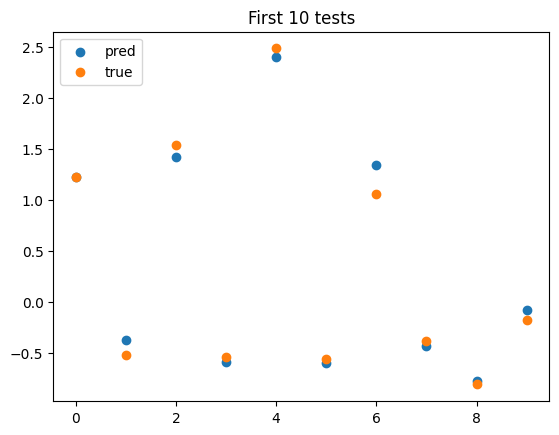

In [656]:
X_test = search_bm.X_test

y_test = search_bm.y_test
y_pred = best_model.predict(X_test)

plt.scatter(range(10), y_pred[:10], label='pred')
plt.scatter(range(10), y_test[:10], label='true')
plt.legend(loc="upper left")
plt.title('First 10 tests')
plt.show()

Good! now, I wanna apply a bit of deep learning

### Deep Learning

In [24]:
import torch

class RegressionModel(torch.nn.Module):
    def __init__(self, cat_features_amount, embedding_dim, num_features_amount):
        super(RegressionModel, self).__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings=cat_features_amount,
            embedding_dim=embedding_dim
        )
        self.relu = torch.nn.ReLU()
        self.sig = torch.nn.Sigmoid()
        self.dense1 = torch.nn.Linear(
            (embedding_dim * cat_features_amount) + num_features_amount,
            512
        )
        self.dense2 = torch.nn.Linear(512, 1024)
        self.dense3 = torch.nn.Linear(1024, 512)
        self.dense4 = torch.nn.Linear(512, 128)
        self.out = torch.nn.Linear(128, 1)

    def forward(self, x_cat, x_num):
        x_cat = self.embedding(x_cat)
        x_cat = x_cat.view(x_cat.size(0), -1)
        x = torch.cat([x_cat, x_num], dim=1)

        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.relu(x)
        x = self.dense4(x)
        x = self.sig(x)
        x = self.out(x)
        return x


In [25]:
from torch.utils.data import DataLoader, Dataset, random_split

class OHEDataset(Dataset):
    def __init__(self, data, cat_features, num_features, label):
        self.data = data
        self.cat_features = cat_features
        self.num_features = num_features
        self.label = label

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        x_num = torch.from_numpy(
            row[self.num_features].to_numpy().astype(np.float32)
        ).view(-1)

        x_cat = torch.from_numpy(
            row[self.cat_features].to_numpy().astype(np.int32)
        ).view(-1)

        target = torch.from_numpy(row[[self.label]].to_numpy().astype(np.float32))
        return x_cat, x_num, target

In [26]:
CATEGORICAL_FEATURES = [
    'cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good',
    'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1', 'clarity_IF',
    'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'
]
NUMERICAL_FEATURES = [
    'carat', 'x'
]
LABEL = 'price'


dataset = OHEDataset(filtered_data, CATEGORICAL_FEATURES, NUMERICAL_FEATURES, LABEL)

train_dataset, test_dataset, val_dataset = random_split(dataset, [0.6, 0.3, 0.1])

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=True)

In [47]:
embedding_dim = 3

model = RegressionModel(len(CATEGORICAL_FEATURES), embedding_dim, len(NUMERICAL_FEATURES))
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Training loop

In [48]:
num_epochs = 50
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_cat, x_num, y in train_loader:
        optimizer.zero_grad()
        pred = model(x_cat, x_num)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_cat.size(0)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_cat, x_num, y in val_loader:
            pred = model(x_cat, x_num)
            loss = loss_fn(pred, y)
            val_loss += loss.item() * x_cat.size(0)

    train_loss = train_loss / len(train_dataset)
    val_loss = val_loss / len(val_dataset)

    if val_loss < best_loss:
        torch.save(model, './best_model.pt')

    print(f'Epoch {epoch+1}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}')


Epoch 1, train_loss: 1.0107, val_loss: 0.7864
Epoch 2, train_loss: 0.6163, val_loss: 0.3444
Epoch 3, train_loss: 0.3620, val_loss: 0.3856
Epoch 4, train_loss: 0.3245, val_loss: 0.2267
Epoch 5, train_loss: 0.2032, val_loss: 0.1690
Epoch 6, train_loss: 0.1753, val_loss: 0.1657
Epoch 7, train_loss: 0.1320, val_loss: 0.1197
Epoch 8, train_loss: 0.1039, val_loss: 0.0977
Epoch 9, train_loss: 0.0914, val_loss: 0.0734
Epoch 10, train_loss: 0.0687, val_loss: 0.0786
Epoch 11, train_loss: 0.0656, val_loss: 0.0761
Epoch 12, train_loss: 0.0563, val_loss: 0.0560
Epoch 13, train_loss: 0.0526, val_loss: 0.0489
Epoch 14, train_loss: 0.0442, val_loss: 0.0481
Epoch 15, train_loss: 0.0408, val_loss: 0.0472
Epoch 16, train_loss: 0.0387, val_loss: 0.0465
Epoch 17, train_loss: 0.0389, val_loss: 0.0406
Epoch 18, train_loss: 0.0345, val_loss: 0.0406
Epoch 19, train_loss: 0.0334, val_loss: 0.0383
Epoch 20, train_loss: 0.0310, val_loss: 0.0358
Epoch 21, train_loss: 0.0298, val_loss: 0.0344
Epoch 22, train_loss: 

#### Testing loop

In [49]:
best_model = torch.load('./best_model.pt')

In [50]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for x_cat, x_num, y in test_loader:
        pred = model(x_cat, x_num)
        loss = loss_fn(pred, y)
        test_loss += loss.item() * x_cat.size(0)

test_loss = test_loss / len(test_dataset)
print(f"Test loss: {test_loss}")

Test loss: 0.031082581150978006


Ok, looks really good. Go compare with our benchmark metrics

In [51]:
model.eval()

preds = []
trues = []
with torch.no_grad():
    for x_cat, x_num, y in test_loader:
        pred = model(x_cat, x_num)
        preds.append(pred)
        trues.append(y)


In [52]:
preds = torch.cat(preds).numpy()
trues = torch.cat(trues).numpy()

In [53]:
results = BenchmarkUtils.compute_metrics(preds, trues)
pd.DataFrame(results, index={'DL': 'model'})

,max_error,root_mean_squared_error,explained_variance_score,mean_absolute_error,r2_score
DL,1.521935,0.176303,0.971076,0.092419,0.970387


Nice! I'm going to use this model for next steps because I love pytorch.

However, note that svm-rbf is better. This demostrate that sometimes simpler is better